In [ ]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../..'))
print(sys.path)
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dyeScreen.MD.sampling import scan_DNAconfig, gen_leap_nolinker, modify_mol2
from dyeScreen.MD.md_samples import md_run, eq_check

from dyeScreen.QM.cluster_trajs import make_feat_matrix

# Directory fix for jupyter notebook
path =  os.path.dirname(os.path.abspath('__file__')) + '/cy3_full'
examples_home = os.path.abspath(os.path.join(path, '..', '..'))

# Amber paths (change if different)
# If saved as an environment variable
amber_path = os.getenv("AMBERPATH")
# If installed in miniconda
# amber_path = "/Users/username/opt/miniconda3/envs/AmberTools23"
# If installed in Nersc 
#amber_path = "/global/common/software/nersc/pm-2021q4/sw/amber/20" 
path_parmchk2 = amber_path + "/bin/parmchk2"

# Define input and output files
samples = path + "/samples"

leap_out = path + "/tleap_screen.in"
dye_mol2 = path + "/cy3-link.mol2"
dye_mol2_rewrite = path + "/cy3-final.mol2"
dye_pdb = path + "/cy3-link.pdb"

# DNA is is a different directory
DNA_pdb = examples_home + "/dna_duplex.pdb"

# Info on the dye molecule (can be extracted from the pdb file)
dye_name = "CY3"
# Atom names for the OPO3H group in the linker
opo3_1 = ['O1','P1','O4','O8','O7','H37']
opo3_2 = ['O2','P2','O3','O5', 'O6', 'H36']

# The atom names that participate in the bonding between the dye and DNA 
# (could be a default and not given by the user? It's not supposed to change)
attach_cy3 = ['P', "O3'"]*2
attach_dna = ["O3'", "P"]*2

# Sample dimers in DNA

In [17]:
# Sample only the positions within 12A of separation and include a box of DX-DNA of 25A
nsamples = scan_DNAconfig(dye_pdb, DNA_pdb, samples, resD=1, resL=None, 
                          chainDNA=None, dist_min=18.5, DNABox=20, DNASt=20,
                          attachment='double', attach_points=[opo3_1,opo3_2], 
                          box_type="doubleAtt") 

atoms count 1330 1330
atoms count 1330 1330
** 14 15 30 27 18.40316
P3- 3
0 100
0: (15,30), P3-DA14&DG15-DG31&DT32
** 17 18 26 24 18.402851
P2- 2
1 100
1: (18,26), P2-DG17&DT18-DT27&DC28
** 6 7 35 35 18.40316
P0- 0
2 100
2: (7,35), P0-DG6&DG7-DC36&DC37
S3- 3
3 100
3: (29,32), S3-DC28&DT29-DT33&DG34
S1- 1
4 100
4: (8,9), S1-DG7&DT8-DA10&DA11
S3- 3
5 100
5: (11,14), S3-DA10&DA11-DG15&DA16
** 9 10 27 32 18.40316
P5- 5
6 100
6: (10,27), P5-DC9&DA10-DC28&DT29
S0- 0
This is a 0nt
7 100
7: (25,25), S0-DC24&DA25-DC26&DT27
** 9 10 36 32 18.40316
P4- 4
8 100
8: (10,36), P4-DC9&DA10-DC37&DG38
S3- 3
9 100
9: (3,6), S3-DG2&DC3-DG7&DT8
S1- 1
10 100
10: (14,15), S1-DG13&DA14-DA16&DG17
** 13 14 24 28 18.402851
P4- 4
11 100
11: (14,24), P4-DG13&DA14-DA25&DC26
** 13 14 33 28 18.402851
P5- 5
12 100
12: (14,33), P5-DG13&DA14-DG34&DA35
S1- 1
13 100
13: (15,16), S1-DA14&DG15-DG17&DT18
** 14 15 25 27 18.40316
P2- 2
14 100
14: (15,25), P2-DA14&DG15-DC26&DT27
** 6 7 30 35 18.40316
P5- 5
15 100
15: (7,30), P5-D

Delete and rename atoms from mol2 so they match the pdb file

In [18]:
modify_mol2([opo3_1, opo3_2], dye_mol2, mol2_out=dye_mol2_rewrite, 
            attachment='double', parmchk2=path_parmchk2)

[58 71 73 74 75 76 77]


Generate input files and run leap 

In [ ]:
gen_leap_nolinker(samples, amber_path, attach_cy3, attach_dna,
                   dye_mol2_rewrite, dye_name=dye_name, wbox=10)

# Run MD trajectories (on HPC)

An example of how to run the MD on a HPC and check for equilibration. The latter will save a file rmsd_{t}.txt or cofm_{t}.txt, containing the metric as a function of time that can be visualized for evaluation.

In [29]:
from MD.md_samples import eq_check

def prefix_md(nodes, num, amber_p):
    logfile = f'cy3_{num}'
    return f'''#!/bin/sh
#SBATCH --nodes={nodes}
#SBATCH --ntasks={int(32)*nodes}
#SBATCH -J {logfile}
#SBATCH --output={logfile}.log

AMBERPATH="{amber_p}"

# Job Submission
'''

# Check which dimers we actually generated MD input files for
i_start, i_end = 0, 100
valid_dimers = []
for i in range(i_start, i_end+1):
    dfile = f"{samples}/dimer_{i}_clean.rst7"
    if os.path.exists(dfile):
        valid_dimers.append(i)
print(len(valid_dimers))          

# To be run on an HPC environment
for dimer_num in valid_dimers:
    slurm_prefix = prefix_md(1, dimer_num, amber_path)
    # md_run(dimer_num, samples, "", sample_frefix='dimer_', pdb=None, param=None, coord=None,
    #        input_prefix='DNA-dye', cutoff=10.0, edges_rest=3.0,
    #        min_cycles=[2000,2000], eq_runtime=[20,100], prod_runtime=5000, dt=0.002,
    #        nodes=1, tasks=32, logfile='',
    #        sander_path='srun $AMBERPATH/bin/sander', slurm_prefix=slurm_prefix))

# Once the run is completed, check if production traj is equilibrated, if not, re-run.    
dimer_num = 1
metric = "cofm"
wdw_min = 50 # in %
window = 1.5 if metric.casefold() == "cofm".casefold() else 0.5
imax = 1 # How many prod have been run so far 

traj_list = [f"dimer_{dimer_num}_eq2.nc", f"dimer_{dimer_num}_prod.nc"] 
traj_list += [f"dimer_{dimer_num}_prod_{i}.nc" for i in range(2, imax+1)]

slurm_prefix = prefix_md(1, dimer_num, amber_path)
# wdw_p = eq_check(dimer_num, path, amber_path, sample_frefix='dimer_',
#                  trajs=traj_list, dye_res='CY3',
#                  prod_runtime=9000, save_time=10, dt=0.002, rmsd_time=100, metric=metric, wdw_min=wdw_min, pass_window=window,
#                  nodes=1, tasks=32, logfile='', iextra=imax+1, edges_rest=3.0, cutoff=10.0,
#                  sander_path='srun $AMBERPATH/bin/sander', slurm_prefix=slurm_prefix)


101


# Analyzing MD trajectories

Visualize CofMass and RMSD along the trajectory

## Visualization 

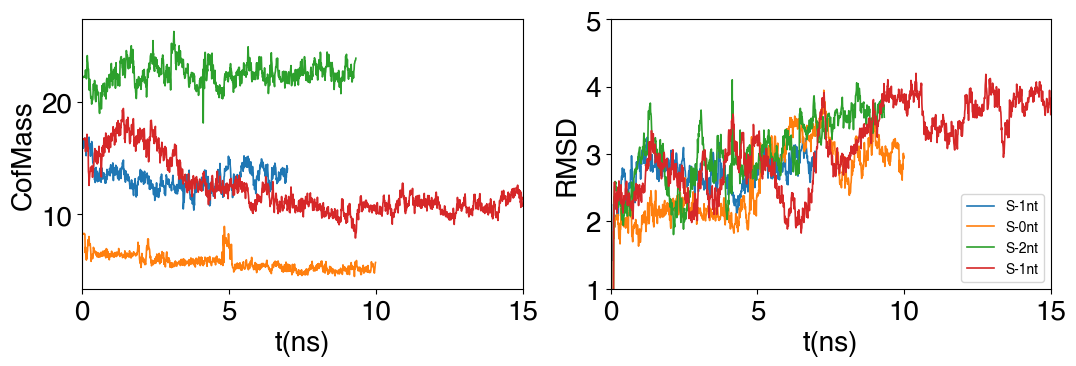

In [45]:
# Serial dimers
import matplotlib
font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

trajs = [10, 22, 23, 54]
labels = ['S-1nt', 'S-0nt', 'S-2nt', 'S-1nt']
fig, (ax1, ax2) = plt.subplots(1,2,sharey=False,figsize=(12.5,3.5))
#plt.title("DNA duplex")
for i, t in enumerate(trajs):
    rmsd = np.loadtxt(f"{samples}/rmsd_{t}.txt")[:-10]
    cofm = np.loadtxt(f"{samples}/cofm_{t}.txt")[:-10]
    time = np.linspace(0,(len(cofm)-1)/100, len(cofm))
    ax1.plot(time, cofm, lw=1.2, label=f"{labels[i]}")
    ax1.set_ylabel("CofMass")
    ax1.set_xlabel("t(ns)")
    ax1.set_xlim(0,15)    
    time = np.linspace(0,(len(rmsd[:,1])-1)/100, len(rmsd[:,1]))
    ax2.plot(time,rmsd[:,1], lw=1.2, label=f"{labels[i]}")
    ax2.set_ylabel("RMSD")
    ax2.set_xlabel("t(ns)")
    ax2.set_xlim(0,15)
    ax2.set_ylim(1,5)
    
plt.legend(loc='lower right',prop={'size': 10})


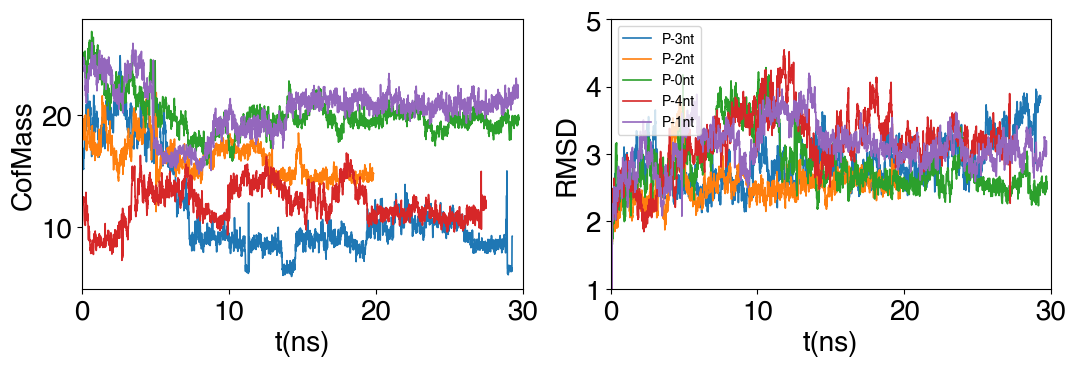

In [43]:
# Parallel dimers

trajs = [0, 1, 2, 8, 17]
labels = ['P-3nt', 'P-2nt', 'P-0nt', 'P-4nt', 'P-1nt']

fig, (ax1, ax2) = plt.subplots(1,2,sharey=False,figsize=(12.5,3.5))
for i, t in enumerate(trajs):
    cofm = np.loadtxt(f"{samples}/cofm_{t}.txt")[:-10]
    time = np.linspace(0,(len(cofm)-1)/100, len(cofm))
    ax1.plot(time, cofm, lw=1.2, label=f"{labels[i]}")
    ax1.set_ylabel("CofMass")
    ax1.set_xlabel("t(ns)")
    ax1.set_xlim(0,30)

    rmsd = np.loadtxt(f"{samples}/rmsd_{t}.txt")[:-10]
    time = np.linspace(0,(len(rmsd[:,1])-1)/100, len(rmsd[:,1]))
    ax2.plot(time,rmsd[:,1], lw=1.2, label=f"{labels[i]}")
    ax2.set_ylabel("RMSD")
    ax2.set_xlabel("t(ns)")
    ax2.set_xlim(0,30)
    ax2.set_ylim(1,5)

#plt.title("DNA duplex")
plt.legend(loc='best', prop={'size': 10})

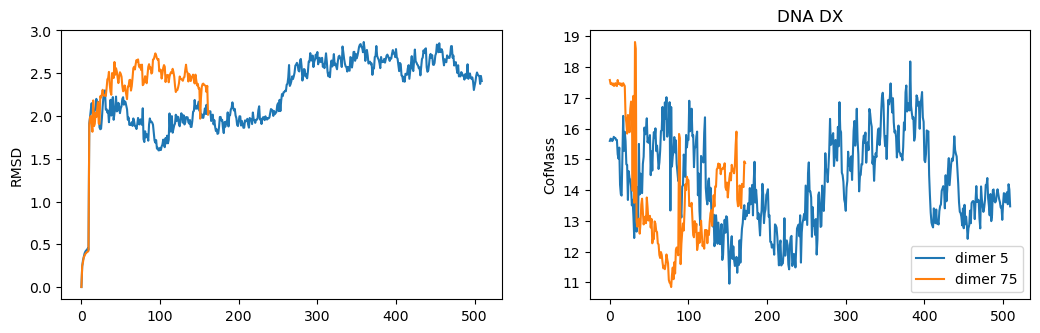

In [4]:
# DX-Tile

import matplotlib.pyplot as plt
trajs = [5, 75]
fig, (ax1, ax2) = plt.subplots(1,2,sharey=False,figsize=(12.5,3.5))
for t in trajs:
    rmsd = np.loadtxt(f"{samples}/rmsd_{t}.txt")
    ax1.plot(rmsd[:,1], label=f"dimer {t}")
    ax1.set_ylabel("RMSD")
    cofm = np.loadtxt(f"{samples}/cofm_{t}.txt")
    ax2.plot(cofm, label=f"dimer {t}")
    ax2.set_ylabel("CofMass")
plt.title("DNA DX")
plt.legend(loc='best')

## Evaluate features

In [ ]:
import matplotlib.pyplot as plt
geom_path = f'{samples}/geom_data'
trajs = [0,10]
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=False,figsize=(14,3.5))
for t in trajs:
    angle = np.loadtxt(f"{geom_path}/dimer_{t}_angleC5-C17.txt")
    ax1.plot(angle[:,0], angle[:,1], label=f"dimer {t}")
    ax1.set_ylabel("Angle")
    cofm = np.loadtxt(f"{geom_path}/dimer_{t}_cofm.txt")
    ax2.plot(cofm[:,0], cofm[:,1], label=f"dimer {t}")
    ax2.set_ylabel("CofMass")
    long_disp = np.loadtxt(f"{geom_path}/dimer_{t}_disp-long.txt")
    ax3.plot(long_disp[:,0], long_disp[:,1], label=f"dimer {t}")
    ax3.set_ylabel("Long axis disp")
plt.legend(loc='best')

In [ ]:
%load_ext autoreload
%autoreload 2

feats_file = '/feats.txt'
traj_path = f"{samples}/prods"
geom_path = f"{samples}/geom_data"

dimers = [0, 1, 2, 8, 17, 54]#, 22, 23]
labels = [f'dimer {i}' for i in dimers]

params = [ f'{traj_path}/dimer_{d}_clean.prmtop' for d in dimers ]
trajs = [ f'{traj_path}/dimer_{d}_prod.nc' for d in dimers ] #+ [ f'{samples}/dimer_{d}_prod_2.nc' for d in dimers0 ]
feat_list = ['cofm', 'angle', 'disp-long', 'disp-short']
vec_atoms = [[],["C5","C17"],["C5","C17"], ["C4","C6"]]
print(params ,'\n',trajs, '\n', feat_list, vec_atoms)

'''
for d in dimers:
    param = f'{traj_path}/dimer_{d}_clean.prmtop'
    traj_file = f'{traj_path}/dimer_{d}_prod_nw.nc'
    mode = "angle" 
    res = cl.import_trajs(traj_file, param=param, dye_res='CY3', dt=2, dt_write=10, 
                          mode=mode, vec_ats=["C5","C17"], save_path=geom_path)
'''

In [ ]:
feat_matrix = make_feat_matrix(trajs, feat_list, params, dye_res='CY3', dt=2, dt_write=10, num_sol=200, 
                               vec_atoms=vec_atoms, save_path=geom_path,
                               feat_file=feats_file, print_tstep=True)

In [33]:
from dyeScreen.QM.cluster_trajs import PCA_cluster, make_cluster_plots
df= pd.read_csv(geom_path + feats_file, sep=" ", header=None)
df_pca_kmeans, kmeans_pca, scores, max_comp = PCA_cluster(df, feat_list, dimers=dimers, print_tstep=True, 
                                                          label_path=samples + "/name_info.txt")
print(df_pca_kmeans.head())

Keeping 2 components
['PCA comp 0 var explained by cofm', 'PCA comp 1 var explained by angle']
Keeping 3 clusters 2
   traj  t_step    cofm     angle  disp-long  disp-short  Component 1  \
0     0       0  7.5356  123.2091     0.5707     -2.7104    -2.644304   
1     0       1  7.5485  128.8362     0.6293     -2.0618    -2.643738   
2     0       2  7.0049  123.8606     0.6028     -0.7761    -2.474921   
3     0       3  7.6745  135.9373     0.6832     -1.2471    -2.603109   
4     0       4  6.9438  133.0506     0.6651     -0.1893    -2.508126   

   Component 2  K-means PCA Cluster Cluster dtype  
0     0.084014                    2      C3    P3  
1    -0.108709                    2      C3    P3  
2    -0.004483                    2      C3    P3  
3    -0.347964                    2      C3    P3  
4    -0.278679                    2      C3    P3  


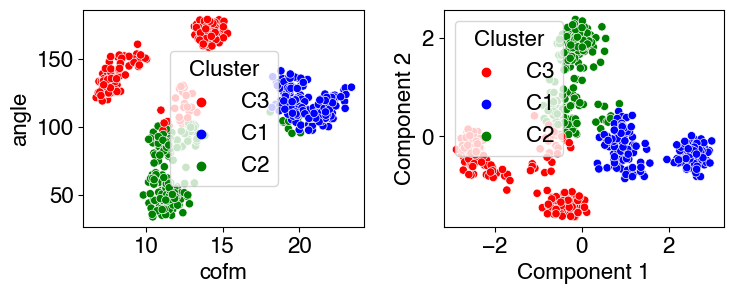

In [34]:
# Serial dimers
import matplotlib
font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(7.5,3.1))
a=sns.scatterplot(ax=axes[0], data=df_pca_kmeans, x=feat_list[max_comp[0]], y=feat_list[max_comp[1]], 
                hue=df_pca_kmeans["Cluster"], palette=['red', 'blue', 'green'])

                
b=sns.scatterplot(ax=axes[1], data=df_pca_kmeans, x="Component 1", y="Component 2", 
                hue=df_pca_kmeans["Cluster"], palette=['red', 'blue', 'green'])
plt.tight_layout(pad=0.8)
plt.show()

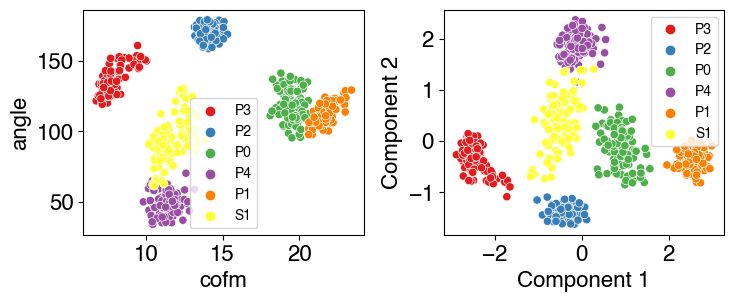

In [35]:
import seaborn as sns

# Defining different colors for each label
labels = df_pca_kmeans['dtype'] 
unique_labels = list(set(labels))
color_palette = sns.color_palette("Set1", len(unique_labels))
label_to_color = {label: color for label, color in zip(unique_labels, color_palette)}
colors = [label_to_color[label] for label in labels]

fig, axes = plt.subplots(1, 2, figsize=(7.5,3.18))
a=sns.scatterplot(ax=axes[0], data=df_pca_kmeans, x=feat_list[max_comp[0]], y=feat_list[max_comp[1]], 
                hue=df_pca_kmeans["dtype"], palette=color_palette)#['red', 'blue', 'green', 'orange'])
                
b=sns.scatterplot(ax=axes[1], data=df_pca_kmeans, x="Component 1", y="Component 2", 
                hue=df_pca_kmeans["dtype"], palette=color_palette)
plt.tight_layout(pad=0.8)
a.legend(fontsize=10)
b.legend(fontsize=10)
plt.show()

In [ ]:
# Or save plots with implemented function
save_scatter_cluster = samples + "/geom_data/clusters.eps"
save_cat_cluster = samples + "/geom_data/clusters_dyes.eps"

make_cluster_plots(df_pca_kmeans, max_comp, feat_list, dimers, 
                   save_scatter_cluster, save_cat_cluster)

Plotting all the features as a function of time

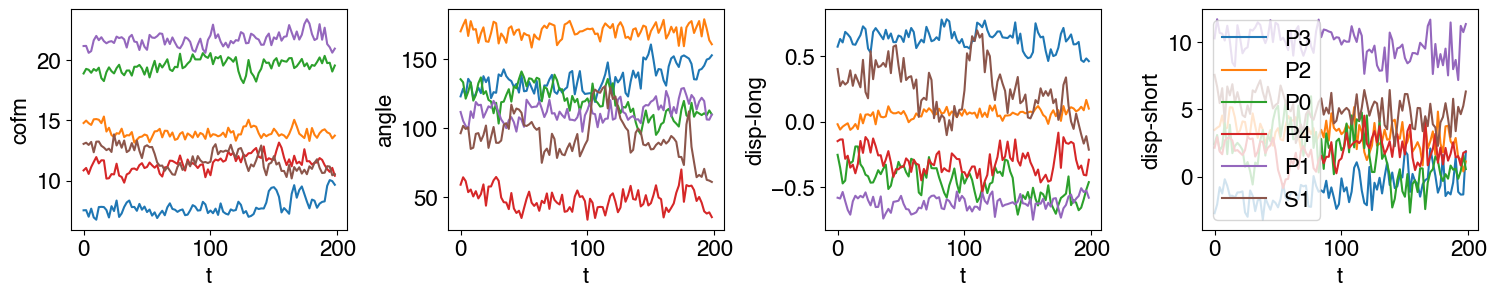

In [ ]:
import matplotlib.pyplot as plt
n_samples = 200
dt = 2
fig, axes = plt.subplots(1,4,sharey=False,figsize=(15,3.))
trajs = [ f'{traj_path}/dimer_{d}_prod.nc' for d in dimers ]
ts = np.arange(0, n_samples, dt)

for ft in range(len(feat_list)):
    samples = int(n_samples/dt)
    start = 0
    for t in range(len(trajs)):
        data = df_pca_kmeans[feat_list[ft]].iloc[start:start+samples]
        hues = df_pca_kmeans["traj"].iloc[start:start+samples]
        label = df_pca_kmeans["dtype"].iloc[start]
        axes[ft].plot(ts, data, label=label)
        axes[ft].set_ylabel(feat_list[ft])
        axes[ft].set_xlabel('t')
        # axes[ft].legend()
        start += samples

plt.tight_layout(pad=0.5)
plt.legend(loc='best')

Find representative samples and save as PDB

In [ ]:
from QM.cluster_trajs import find_cluster_rep, find_cluster_limits

reps = find_cluster_rep(kmeans_pca, scores)
nclusters = kmeans_pca.n_clusters
rep_labels = [df_pca_kmeans['dtype'].iloc[reps[k]] for k in range(nclusters)]
rep_samples = [df_pca_kmeans['traj'].iloc[reps[k]] for k in range(nclusters)]
print(rep_labels, rep_samples)
# Traj files of representative samples
params_rep = [ f'{traj_path}/dimer_{d}_clean.prmtop' for d in rep_samples ]
trajs_rep = [ f'{traj_path}/dimer_{d}_prod.nc' for d in rep_samples ]
print(params_rep)

# Samples at the limit of the clusters
num_lim = 3
lim = find_cluster_limits(kmeans_pca, scores, num_max=num_lim)
nclusters = kmeans_pca.n_clusters
lim_labels = [np.unique([df_pca_kmeans['dtype'].iloc[lim[k][j]] for j in range(num_lim)])[0] for k in range(nclusters)]
lim_samples = [np.unique([df_pca_kmeans['traj'].iloc[lim[k][j]] for j in range(num_lim)])[0] for k in range(nclusters)]
print(lim_labels)

In [ ]:
from QM.cluster_trajs import get_sample_pdb
for r, rep in enumerate(reps):
    get_sample_pdb(df_pca_kmeans, rep, traj_path, samples+"/geom_data", 2, r+1, dye_res='CY3', tcol='traj')

    # Example of running QM on hpc 
    #save_V, save_abs, V_list = QM_of_sample(df_pca_kmeans, rep, traj_path, samples+"/geom_data", 2, r+1, dye_res='CY3',
    #                                           tcol='traj', basis = "3-21g", xc = "b3lyp",
    #                                           ch=1, sp=1, scf_cycles=500, mode="Vexc", slurm_prefix=prefix))
    #print("Final V is: ", save_V)